## Titanic - Simple Gender + Family Group Model

Greetings! This notebook outlines a somewhat different approach to creating a predictive model using the Titanic dataset.

After trying (and failing) to score higher than ~78% using numerous variations of stacked ensembles, I decided to take a step back. Increasing complexity was obviously not increasing model accuracy. Perhaps if I better understood the problem and increased my domain knowledge, I would have a better chance of moving up the leaderboard.

I stumbled across an interesting notebook by [Chris Deotte](https://www.kaggle.com/cdeotte) in which he creates a relatively high-scoring model using the Name feature alone: [Titanic using Name only](https://www.kaggle.com/cdeotte/titanic-using-name-only-0-81818). Although parsing his R code was a bit of a challenge, Chris' commentary was extremely clear and logical. The basic premise is that we can infer family groups based on passenger last name, which is extracted from the Name field. Survival within these so-called "woman-child-groups" is almost always binary - either all members of the WCG die or all survive. Therefore, if a test case is presented for which we can determine family group status, we should predict survival based on the survival of the family group. Using this group-based strategy in conjunction with the baseline gender-based model in which all men die and all females survive results in an accuracy in the low 80%s. Having spent ages trying to perfect a more complicated stacked ensemble with no improvement, I decided to explore Chris' ideas and implement them in Python. Who knows, maybe I could find an enhancement or two!

### Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, KFold, RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import SVC
import xgboost as xgb

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

SEED = 42
NFOLDS = 10

train_ = pd.read_csv("assets/train.csv")
test_ = pd.read_csv("assets/test.csv")

In [2]:
test = test_.copy()
train = train_.copy()
test_train = pd.concat([test, train], sort=False)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Data Preprocessing

**Title**

In [3]:
def extract_title(x):
    return x.split(', ')[1].split(". ")[0].strip()

In [4]:
for dataset in [train, test, test_train]:
    dataset["Title"] = dataset["Name"].apply(extract_title)

**Last Name**

In [5]:
def extract_last_name(x):
    return x.split(",")[0].strip()

In [6]:
for dataset in [train, test, test_train]:
    dataset["LastName"] = dataset["Name"].apply(extract_last_name)

**Age**

In [7]:
for dataset in [train, test, test_train]:
    dataset["Age"] = dataset["Age"].fillna(99)

**Fare**

In [8]:
for dataset in [train, test, test_train]:
    dataset["Fare"] = dataset["Fare"].fillna(0)

**Embarked**

In [9]:
for dataset in [train, test, test_train]:
    dataset["Embarked"] = dataset["Embarked"].fillna(dataset["Embarked"].mode()[0])

I decided to add several new features to the dataset to use as diagnostics when grouping families. I've noticed that many notebooks mention how SibSp and Parch are inaccurate, so we'll take any metrics based on these features with a grain of salt.

**Family Size**

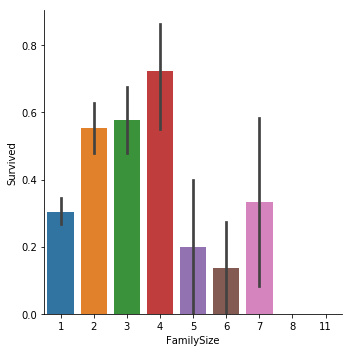

In [10]:
for dataset in [train, test, test_train]:
    dataset["FamilySize"] = dataset["SibSp"] + dataset["Parch"] + 1
    
sns.catplot(x="FamilySize", y="Survived", data=train, kind="bar")
plt.show()

**Solo Travelers**

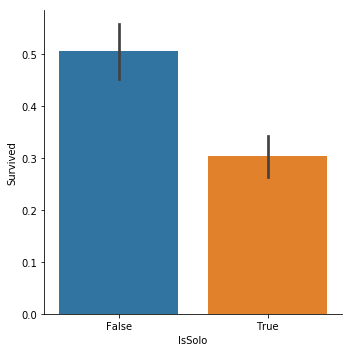

In [11]:
for dataset in [train, test, test_train]:
    dataset["IsSolo"] = dataset["FamilySize"] == 1

sns.catplot(x="IsSolo", y="Survived", data=train, kind="bar")
plt.show()

**Family Groups**

We can observe that, in general, family groups share a last name, a ticket number and fare amount. However, in some cases, the last digit of the ticket number varies within family groups (ex: Vander Planke family) and occasionally the fare amounts don't match. Deciding how to group families is critical for this strategy to be effective.

On my first pass, I constructed FamilyGroup using Last Name + Ticket[:-1] (ignoring Fare). This model produced a LB score in the low 80%s. I've left the code in, below, for clarity - labeled FamilyGroupOld.

On my second pass, I constructed FamilyGroup using Pclass + Ticket[:-1] + Embarked + Fare. This model produced a LB score in the low 81%s. More analysis is needed to determine whether this feature misses any of the information of the original last name-based version. Perhaps both methods should be used in conjuction?

In [12]:
for dataset in [train, test, test_train]:
    dataset["FamilyGroup"] = dataset["Pclass"].astype(str) + " - " + dataset["Ticket"].str[:-1] + " - " + dataset["Embarked"] + " - " + dataset["Fare"].astype(str)
    dataset["FamilyGroupOld"] = dataset["LastName"] + " - " + dataset["Ticket"].str[:-1]

We can look at passengers by last name to verify our FamilyGroup feature.

In [13]:
train.loc[train["LastName"] == "Andersson"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,LastName,FamilySize,IsSolo,FamilyGroup,FamilyGroupOld
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S,Mr,Andersson,7,False,3 - 34708 - S - 31.275,Andersson - 34708
68,69,1,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,7.9250,NaN,S,Miss,Andersson,7,False,3 - 310128 - S - 7.925,Andersson - 310128
119,120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.2750,NaN,S,Miss,Andersson,7,False,3 - 34708 - S - 31.275,Andersson - 34708
146,147,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S,Mr,Andersson,1,True,3 - 35004 - S - 7.7958,Andersson - 35004
541,542,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.2750,NaN,S,Miss,Andersson,7,False,3 - 34708 - S - 31.275,Andersson - 34708
542,543,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.2750,NaN,S,Miss,Andersson,7,False,3 - 34708 - S - 31.275,Andersson - 34708
610,611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.2750,NaN,S,Mrs,Andersson,7,False,3 - 34708 - S - 31.275,Andersson - 34708
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,Miss,Andersson,7,False,3 - 34708 - S - 31.275,Andersson - 34708
850,851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.2750,NaN,S,Master,Andersson,7,False,3 - 34708 - S - 31.275,Andersson - 34708


In [14]:
train.loc[train["FamilyGroup"] == "3 - 34708 - S - 31.275"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,LastName,FamilySize,IsSolo,FamilyGroup,FamilyGroupOld
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.275,NaN,S,Mr,Andersson,7,False,3 - 34708 - S - 31.275,Andersson - 34708
119,120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.275,NaN,S,Miss,Andersson,7,False,3 - 34708 - S - 31.275,Andersson - 34708
541,542,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.275,NaN,S,Miss,Andersson,7,False,3 - 34708 - S - 31.275,Andersson - 34708
542,543,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.275,NaN,S,Miss,Andersson,7,False,3 - 34708 - S - 31.275,Andersson - 34708
610,611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.275,NaN,S,Mrs,Andersson,7,False,3 - 34708 - S - 31.275,Andersson - 34708
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.275,NaN,S,Miss,Andersson,7,False,3 - 34708 - S - 31.275,Andersson - 34708
850,851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.275,NaN,S,Master,Andersson,7,False,3 - 34708 - S - 31.275,Andersson - 34708


In [15]:
train.loc[train["LastName"] == "Vander Planke"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,LastName,FamilySize,IsSolo,FamilyGroup,FamilyGroupOld
18,19,0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",female,31.0,1,0,345763,18.0,NaN,S,Mrs,Vander Planke,2,False,3 - 34576 - S - 18.0,Vander Planke - 34576
38,39,0,3,"Vander Planke, Miss. Augusta Maria",female,18.0,2,0,345764,18.0,NaN,S,Miss,Vander Planke,3,False,3 - 34576 - S - 18.0,Vander Planke - 34576
333,334,0,3,"Vander Planke, Mr. Leo Edmondus",male,16.0,2,0,345764,18.0,NaN,S,Mr,Vander Planke,3,False,3 - 34576 - S - 18.0,Vander Planke - 34576


**Masters**

An important part of the grouping strategy is identifying the young boys who traveled with female passengers. These individuals are given the title "Master".

In [16]:
train[train["Title"] == "Master"].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,LastName,FamilySize,IsSolo,FamilyGroup,FamilyGroupOld
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,Master,Palsson,5,False,3 - 34990 - S - 21.075,Palsson - 34990
16,17,0,3,"Rice, Master. Eugene",male,2.0,4,1,382652,29.1250,NaN,Q,Master,Rice,6,False,3 - 38265 - Q - 29.125,Rice - 38265
50,51,0,3,"Panula, Master. Juha Niilo",male,7.0,4,1,3101295,39.6875,NaN,S,Master,Panula,6,False,3 - 310129 - S - 39.6875,Panula - 310129
59,60,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9000,NaN,S,Master,Goodwin,8,False,3 - CA 214 - S - 46.9,Goodwin - CA 214
63,64,0,3,"Skoog, Master. Harald",male,4.0,3,2,347088,27.9000,NaN,S,Master,Skoog,6,False,3 - 34708 - S - 27.9,Skoog - 34708


The first thing I wondered is whether the title "Master" was only given to young boys. What is the distribution of ages of passengers with the title "Master"?

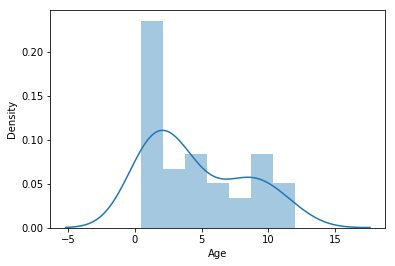

In [17]:
masters = train.loc[(train["Title"] == "Master") & (train["Age"] != 99)]
sns.distplot(masters["Age"].dropna(), bins=7)
plt.ylabel("Density")
plt.show()

The maximum age of passengers with the title "Master" is 14 (in the training dataset).

In [18]:
masters["Age"].describe()

count    36.000000
mean      4.574167
std       3.619872
min       0.420000
25%       1.000000
50%       3.500000
75%       8.000000
max      12.000000
Name: Age, dtype: float64

Are there any young men that do not have the title "Master"?

In [19]:
boys_without_master = train.loc[(train["Age"] < 18) & (train["Sex"] == "male") & (train["Title"] != "Master")]
boys_without_master

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,LastName,FamilySize,IsSolo,FamilyGroup,FamilyGroupOld
86,87,0,3,"Ford, Mr. William Neal",male,16.0,1,3,W./C. 6608,34.3750,NaN,S,Mr,Ford,5,False,3 - W./C. 660 - S - 34.375,Ford - W./C. 660
138,139,0,3,"Osen, Mr. Olaf Elon",male,16.0,0,0,7534,9.2167,NaN,S,Mr,Osen,1,True,3 - 753 - S - 9.2167,Osen - 753
163,164,0,3,"Calic, Mr. Jovo",male,17.0,0,0,315093,8.6625,NaN,S,Mr,Calic,1,True,3 - 31509 - S - 8.6625,Calic - 31509
220,221,1,3,"Sunderland, Mr. Victor Francis",male,16.0,0,0,SOTON/OQ 392089,8.0500,NaN,S,Mr,Sunderland,1,True,3 - SOTON/OQ 39208 - S - 8.05,Sunderland - SOTON/OQ 39208
266,267,0,3,"Panula, Mr. Ernesti Arvid",male,16.0,4,1,3101295,39.6875,NaN,S,Mr,Panula,6,False,3 - 310129 - S - 39.6875,Panula - 310129
282,283,0,3,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,345778,9.5000,NaN,S,Mr,de Pelsmaeker,1,True,3 - 34577 - S - 9.5,de Pelsmaeker - 34577
333,334,0,3,"Vander Planke, Mr. Leo Edmondus",male,16.0,2,0,345764,18.0000,NaN,S,Mr,Vander Planke,3,False,3 - 34576 - S - 18.0,Vander Planke - 34576
352,353,0,3,"Elias, Mr. Tannous",male,15.0,1,1,2695,7.2292,NaN,C,Mr,Elias,3,False,3 - 269 - C - 7.2292,Elias - 269
433,434,0,3,"Kallio, Mr. Nikolai Erland",male,17.0,0,0,STON/O 2. 3101274,7.1250,NaN,S,Mr,Kallio,1,True,3 - STON/O 2. 310127 - S - 7.125,Kallio - STON/O 2. 310127
500,501,0,3,"Calic, Mr. Petar",male,17.0,0,0,315086,8.6625,NaN,S,Mr,Calic,1,True,3 - 31508 - S - 8.6625,Calic - 31508


In [20]:
len(boys_without_master)

22

As we see, there are 29 young males in the training set who are under 18 years of age but do not have the title "Master". We might consider broadening our definition of "boy" to include these individuals.

**Potential Families**

In our model, families consist of 2 or more females + masters who share the same FamilyGroup. Let's count the number of such individuals in our training, test and combined dataset. We can then calculate the training survival rate.

In [21]:
test_train_group_count = test_train.loc[(test_train["Sex"] == "female") | (test_train["Title"] == "Master")].groupby("FamilyGroup").count()[["PassengerId"]].sort_index()
test_train_group_count.columns = ["Train + Test Count"]

train_group_count = pd.merge(train.loc[(train["Sex"] == "female") | (train["Title"] == "Master")].groupby("FamilyGroup").count()[["PassengerId"]], 
                             train.loc[(train["Sex"] == "female") | (train["Title"] == "Master")].groupby("FamilyGroup").sum()[["Survived"]], how="inner", on="FamilyGroup")
train_group_count.columns = ["Train Count", "Survived"]

test_group_count = test.loc[(test["Sex"] == "female") | (test["Title"] == "Master")].groupby("FamilyGroup").count()[["PassengerId"]].sort_index()
test_group_count.columns = ["Test Count"]

In [22]:
groups = pd.merge(pd.merge(test_train_group_count, train_group_count, how="left", on="FamilyGroup"), test_group_count, how="left", on="FamilyGroup")
groups["Train Survival Rate"] = groups["Survived"] / groups["Train Count"]
groups = groups.reset_index()
groups.head()

,FamilyGroup,Train + Test Count,Train Count,Survived,Test Count,Train Survival Rate
0,1 - 11015 - S - 86.5,3,3.0,3.0,NaN,1.0
1,1 - 11041 - S - 79.65,2,2.0,2.0,NaN,1.0
2,1 - 11081 - C - 75.25,1,1.0,1.0,NaN,1.0
3,1 - 11136 - C - 57.9792,2,2.0,2.0,NaN,1.0
4,1 - 11205 - S - 30.0,1,1.0,1.0,NaN,1.0


As mentioned above, I originally constructed FamilyGroup using passenger last name. However there were a handful of occasions when this resulted in individuals being left out of groups because they had a different last name. For this reason, I selected a different grouping method using Ticket, Embarked and Fare. Below is a comparison of the number of passengers in each new FamilyGroup compared to the original method.

In [23]:
temp = test_train.sort_values(by="Ticket")
fg_counts1 = temp.groupby("FamilyGroup").count().iloc[:,0]
fg_counts2 = temp.groupby("FamilyGroupOld").count().iloc[:,0]

fg_comparison = pd.merge(pd.merge(temp[["PassengerId", "FamilyGroup", "FamilyGroupOld"]], fg_counts1, on="FamilyGroup", how="left"), fg_counts2, on="FamilyGroupOld", how="left")
fg_comparison.columns = ["PassengerId", "FamilyGroup", "FamilyGroupOld", "CountFamilyGroup", "CountFamilyGroupOld"]
fg_comparison["CountFamilyGroup"] = fg_comparison["CountFamilyGroup"].astype(int)
fg_comparison = fg_comparison.sort_values(by="FamilyGroup")
fg_comparison[fg_comparison["CountFamilyGroup"] != fg_comparison["CountFamilyGroupOld"]].head()

,PassengerId,FamilyGroup,FamilyGroupOld,CountFamilyGroup,CountFamilyGroupOld
0,760,1 - 11015 - S - 86.5,Rothes - 11015,3,1
1,505,1 - 11015 - S - 86.5,Maioni - 11015,3,1
2,258,1 - 11015 - S - 86.5,Cherry - 11015,3,1
6,111,1 - 11046 - S - 52.0,Porter - 11046,2,1
7,476,1 - 11046 - S - 52.0,Clifford - 11046,2,1


Let's double check a few family groups to make sure our counting is correct.

Filtering for FamilyGroup "1 - 11081 - C - 75.25" - there should be 1 passenger in the training set who survived:

In [24]:
train[train["FamilyGroup"] == "1 - 11081 - C - 75.25"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,LastName,FamilySize,IsSolo,FamilyGroup,FamilyGroupOld
366,367,1,1,"Warren, Mrs. Frank Manley (Anna Sophia Atkinson)",female,60.0,1,0,110813,75.25,D37,C,Mrs,Warren,2,False,1 - 11081 - C - 75.25,Warren - 11081


Now let's look at FamilyGroup "1 - 11378 - S - 151.55" - there should be 4 passengers in the training set, 2 of whom survived:

In [25]:
train[train["FamilyGroup"] == "1 - 11378 - S - 151.55"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,LastName,FamilySize,IsSolo,FamilyGroup,FamilyGroupOld
297,298,0,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.55,C22 C26,S,Miss,Allison,4,False,1 - 11378 - S - 151.55,Allison - 11378
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.55,C22 C26,S,Master,Allison,4,False,1 - 11378 - S - 151.55,Allison - 11378
498,499,0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.55,C22 C26,S,Mrs,Allison,4,False,1 - 11378 - S - 151.55,Allison - 11378
708,709,1,1,"Cleaver, Miss. Alice",female,22.00,0,0,113781,151.55,NaN,S,Miss,Cleaver,1,True,1 - 11378 - S - 151.55,Cleaver - 11378


It looks like our counts are correct. Now we can filter for groups of 2 or more passengers.

In [26]:
familygroups = groups[groups["Train + Test Count"] > 1][["FamilyGroup"]]
familygroups.head()

,FamilyGroup
0,1 - 11015 - S - 86.5
1,1 - 11041 - S - 79.65
3,1 - 11136 - C - 57.9792
6,1 - 11237 - C - 59.4
8,1 - 11350 - C - 211.5


In [27]:
families = groups[groups["FamilyGroup"].isin(familygroups["FamilyGroup"])]
families.head()

,FamilyGroup,Train + Test Count,Train Count,Survived,Test Count,Train Survival Rate
0,1 - 11015 - S - 86.5,3,3.0,3.0,NaN,1.0
1,1 - 11041 - S - 79.65,2,2.0,2.0,NaN,1.0
3,1 - 11136 - C - 57.9792,2,2.0,2.0,NaN,1.0
6,1 - 11237 - C - 59.4,2,NaN,NaN,2.0,NaN
8,1 - 11350 - C - 211.5,2,NaN,NaN,2.0,NaN


### Generating Predictions

We're ready to make predictions using our model.

First, all males without the title "Master" are predicted to die.

In [28]:
test_males_xmasters_ids = test.loc[(test["Sex"] == "male") & (test["Title"] != "Master")]["PassengerId"]
test_females_masters_ids = test.loc[(test["Sex"] == "female") | (test["Title"] == "Master")]["PassengerId"]

In [29]:
test_males_xmasters_preds = pd.DataFrame({"PassengerId": test_males_xmasters_ids, "Survived": np.zeros(len(test_males_xmasters_ids), dtype=int)})
test_males_xmasters_preds.head()

,PassengerId,Survived
0,892,0
2,894,0
3,895,0
5,897,0
7,899,0


In [30]:
len(test_males_xmasters_preds)

245

Next, all females and males with the title "Master" follow the fortunes of their group members. If survival rate for the group is greater than 50%, test cases are predicted to survive.

In [31]:
test_females_masters = test.loc[test["PassengerId"].isin(test_females_masters_ids)]
test_females_masters_rates = pd.merge(test_females_masters, groups, how="left", on="FamilyGroup")[["PassengerId", "FamilyGroup", "Sex", "Age", "Train + Test Count", "Train Count", "Survived", "Train Survival Rate"]]
test_females_masters_rates["Train Survival Rate"].fillna(-1, inplace=True)
test_females_masters_rates.head()

,PassengerId,FamilyGroup,Sex,Age,Train + Test Count,Train Count,Survived,Train Survival Rate
0,893,3 - 36327 - S - 7.0,female,47.0,1,NaN,NaN,-1.0
1,896,3 - 310129 - S - 12.2875,female,22.0,2,1.0,1.0,1.0
2,898,3 - 33097 - Q - 7.6292,female,30.0,1,NaN,NaN,-1.0
3,900,3 - 265 - C - 7.2292,female,18.0,1,NaN,NaN,-1.0
4,904,1 - 2122 - S - 82.2667,female,23.0,1,NaN,NaN,-1.0


In [32]:
test_females_masters_rates["Prediction"] = np.zeros(len(test_females_masters_rates), dtype=int)
test_females_masters_rates.loc[(test_females_masters_rates["Sex"] == "female"), "Prediction"] = 1
test_females_masters_rates.loc[(test_females_masters_rates["Train Survival Rate"] >= 0.5), "Prediction"] = 1
test_females_masters_rates.loc[(test_females_masters_rates["Train Survival Rate"] < 0.5) & (test_females_masters_rates["Train Survival Rate"] != -1), "Prediction"] = 0
test_females_masters_rates.head()

,PassengerId,FamilyGroup,Sex,Age,Train + Test Count,Train Count,Survived,Train Survival Rate,Prediction
0,893,3 - 36327 - S - 7.0,female,47.0,1,NaN,NaN,-1.0,1
1,896,3 - 310129 - S - 12.2875,female,22.0,2,1.0,1.0,1.0,1
2,898,3 - 33097 - Q - 7.6292,female,30.0,1,NaN,NaN,-1.0,1
3,900,3 - 265 - C - 7.2292,female,18.0,1,NaN,NaN,-1.0,1
4,904,1 - 2122 - S - 82.2667,female,23.0,1,NaN,NaN,-1.0,1


In [84]:
len(test_females_masters_rates)

173

### Creating a Submission Output

That's it! Let's generate a submission output.

In [60]:
test_females_masters_preds = test_females_masters_rates[["PassengerId", "Prediction"]]
test_females_masters_preds.columns = ["PassengerId", "Survived"]
output = pd.concat([test_males_xmasters_preds, test_females_masters_preds]).sort_values(by="PassengerId")
#output.to_csv("submission.csv", index=False)
output.head()

,PassengerId,Survived
0,892,0
0,893,1
2,894,0
3,895,0
1,896,1


We're predicting that 150 individuals survived. Note that this is not the same number of total females in the test dataset, hence our group model has deviated slightly from the baseline gender model.

In [61]:
np.sum(output["Survived"])

150

In [62]:
len(test[test["Sex"] == "female"])

152

### RF Experimentation

In [116]:
temp = pd.merge(train.loc[(train["Sex"] == "female") | (train["Title"] == "Master")], groups, on="FamilyGroup", how="left")


y_train = temp["Survived_x"]
X_train = pd.DataFrame({"Age": temp["Age"],
                        "Train Survival Rate": temp["Train Survival Rate"],
                        "Train Count": temp["Train Count"]})

X_train.loc[X_train["Train Count"] == 1, "Train Count"] = 0
X_train.loc[X_train["Train Count"] > 1, "Train Count"] = 1
X_train = X_train.fillna(0)
X_train.head()

,Age,Train Survival Rate,Train Count
0,38.0,1.0,0.0
1,26.0,1.0,1.0
2,35.0,1.0,1.0
3,2.0,0.0,1.0
4,27.0,1.0,1.0


In [121]:
temp = pd.merge(test.loc[(test["Sex"] == "female") | (test["Title"] == "Master")], groups, on="FamilyGroup", how="left")

X_test = pd.DataFrame({"PassengerId": temp["PassengerId"],
                        "Age": temp["Age"],
                        "Train Survival Rate": temp["Train Survival Rate"],
                        "Train + Test Count": temp["Train + Test Count"]})
test_females_masters_ids = X_test.pop("PassengerId")

X_test.loc[X_test["Train + Test Count"] == 1, "Train + Test Count"] = 0
X_test.loc[X_test["Train + Test Count"] > 1, "Train + Test Count"] = 1
X_test = X_test.fillna(0)
X_test.head()

,Age,Train Survival Rate,Train + Test Count
0,47.0,0.0,0
1,22.0,1.0,1
2,30.0,0.0,0
3,18.0,0.0,0
4,23.0,0.0,0


In [122]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RandomizedSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier

In [123]:
rf = RandomForestClassifier(random_state=SEED)

rf_random_param = {'n_estimators': [200, 400, 600],
     'min_samples_split': [2, 4, 6, 8],
     'min_samples_leaf': [2, 3, 4, 5],
     'max_features': ['auto'],
     'max_depth': [3, 4, 5],
     'bootstrap': [True]}

rf_random = RandomizedSearchCV(estimator=rf, n_iter=100, param_distributions=rf_random_param, cv=10, random_state=SEED, n_jobs=5)

rf_random.fit(X_train, y_train)
# cv_results = cross_validate(rf, X_train, y_train, cv=10, return_train_score=True)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=5,
          param_distributions={'n_estimators': [200, 400, 600], 'min_samples_split': [2, 4, 6, 8], 'min_samples_leaf': [2, 3, 4, 5], 'max_features': ['auto'], 'max_depth': [3, 4, 5], 'bootstrap': [True]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [126]:
rf_random_p = {'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 5,
 'bootstrap': True}

#rf_random.best_params_

In [127]:
rf_random.best_score_

0.9774011299435028

In [128]:
# print("Train Score: {}\nTest Score: {}\nFit Time: {}\nTest Stdev * 3: {}\n".format(
#     cv_results["train_score"].mean(), 
#     cv_results["test_score"].mean(), 
#     cv_results["fit_time"].mean(), 
#     cv_results["test_score"].std()*3))

# Train Score: 0.8694357627339355
# Test Score: 0.8136411871524232
# Fit Time: 0.057918882369995116
# Test Stdev * 3: 0.09254083199285038

In [129]:
rf = RandomForestClassifier(random_state=SEED, **rf_random_p)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

In [130]:
test_females_masters_preds_rf = pd.DataFrame({"PassengerId": test_females_masters_ids, "Survived": preds})
output_rf = pd.concat([test_males_xmasters_preds, test_females_masters_preds_rf]).sort_values(by="PassengerId")
output_rf.to_csv("submissions/groups_rf_2.csv", index=False)
output_rf.head()

,PassengerId,Survived
0,892,0
0,893,0
2,894,0
3,895,0
1,896,1


In [131]:
x = pd.merge(output, output_rf, on="PassengerId", how="left")
np.sum(x["Survived_x"]), np.sum(x["Survived_y"])

(150, 66)

In [133]:
y = pd.read_csv("submissions/groups_rf_2.csv")
np.sum(y["Survived"])

66

### Conclusion

Thanks so much for reading. I had a lot of fun exploring this strategy and have a few ideas for using a simple decision tree model to generate predictions for the female + master population. If I have any success, I will create a new notebook :)

Please leave a comment below with your thoughts and ideas to improve the women-child-group strategy.

Until next time, happy coding.